## 1. Library Importing

In [1]:
import nltk # 텍스트 데이터를 처리
import numpy as np # 말뭉치를 배열로 표현
import random
import operator
import string # 표준 파이썬 문자열을 처리
import re
from sklearn.metrics.pairwise import cosine_similarity # 이를 나중에 사용하여 두 개의 문장이 얼마나 비슷한지를 결정합니다.
from sklearn.feature_extraction.text import TfidfVectorizer # Experience 2에서 단어 가방을 만드는 함수를 만들었던 것을 기억하십니까? 이 함수는 같은 일을 합니다!
import re

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # LogisticRegression import 추가

import os
import numpy as np
from google.colab import drive

## 2. Data Uploading

In [5]:
  # Colab에서 Google 드라이브를 마운트하기 위한 라이브러리

# 구글 드라이브 마운트
drive.mount('/content/drive')

def loadfile(path):
    X = []
    Y = []

    for label in ('0', '25', '50', '75', '100'):
        print("Loading text files for the label: " + label)

        label_path = os.path.join(path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.txt'):
                with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()

                # 레이블을 숫자로 변환
                if label == '0':
                    Y.append(0)
                elif label == '25':
                    Y.append(1)
                elif label == '50':
                    Y.append(2)
                elif label == '75':
                    Y.append(3)
                elif label == '100':
                    Y.append(4)

                # 텍스트 데이터를 X에 추가
                X.append(text)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# 경로를 구글 드라이브 경로로 변경
directory_path = '/content/drive/MyDrive/likeability_final/'

# loadfile 함수 호출
X, Y = loadfile(directory_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading text files for the label: 0
Loading text files for the label: 25
Loading text files for the label: 50
Loading text files for the label: 75
Loading text files for the label: 100


In [6]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (1577,)
Y shape: (1577,)


In [7]:
def count_txt_files(path):
    file_counts = {}

    for label in ('0', '25', '50', '75', '100'):
        label_path = os.path.join(path, label)
        txt_files = [filename for filename in os.listdir(label_path) if filename.endswith('.txt')]
        file_counts[label] = len(txt_files)

    return file_counts

# .txt 파일 수 확인
file_counts = count_txt_files(directory_path)

# 결과 출력
for label, count in file_counts.items():
    print(f"Number of .txt files in label {label}: {count}")

Number of .txt files in label 0: 365
Number of .txt files in label 25: 300
Number of .txt files in label 50: 305
Number of .txt files in label 75: 303
Number of .txt files in label 100: 304


## 3. 호감도 가중치 증가


In [8]:
#3-1. 이모지 사용 함수
def count_emojis(text):
    emoji_pattern = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        ']', flags=re.UNICODE)
    return len(emoji_pattern.findall(text))


# 3-2. 대화 양방향성 관련 함수
def check_bidirectional_conversation(text):
    a_contributions = len(re.findall(r'A:', text))
    b_contributions = len(re.findall(r'B:', text))
    return a_contributions > 0 and b_contributions > 0


# 3-3. 답장 속도 기반 호감도 예측
from datetime import datetime
import re
import numpy as np
# 대화 데이터를 .txt 파일에서 불러오기
conversation = []
for label in ('0', '25', '50', '75', '100'):
    label_path = os.path.join(directory_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.txt'):
            with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                conversation.extend(file.readlines())


# 호감도 레이블 생성 함수
def create_likeability_labels(conversation):
    response_times = []
    last_message_time = None
    for line in conversation:
        if line.startswith("A:") or line.startswith("B:"):
            # 시간 정보 추출 및 변환
            time_str = re.search(r'\((\d{2}):(\d{2})\)', line)
            if time_str:
                hours, minutes = map(int, time_str.groups())
                current_time = hours * 60 + minutes  # Convert to minutes
                # 답장 속도 계산
                if last_message_time is not None:
                    response_time = current_time - last_message_time
                    response_times.append(response_time)
                last_message_time = current_time
    # 평균 응답 시간 계산 및 호감도 레이블 생성
    avg_response_times = np.mean(response_times) if response_times else 0
    likeability_labels = []
    for response_time in response_times:
        if response_time <= 10:
            likeability = 100
        elif response_time <= 30:
            likeability = 75
        elif response_time <= 60:
            likeability = 50
        elif response_time <= 180:
            likeability = 25
        else:
            likeability = 0
        likeability_labels.append(likeability)
    return likeability_labels
# 대화 데이터를 기반으로 호감도 레이블 생성
likeability_labels = create_likeability_labels(conversation)

## 4.데이터 정제

In [11]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 증강 함수
def augment_text(text, num_augments=1):
    words = text.split()
    augmented_texts = []

    for _ in range(num_augments):
        random.shuffle(words)
        augmented_texts.append(' '.join(words))

    return augmented_texts

# 원본 데이터에 대한 데이터 증강
augmented_X = []
augmented_Y = []

for text, label in zip(X, Y):
    augmented_texts = augment_text(text, num_augments=2)  # 각 텍스트당 2개의 증강된 텍스트 생성
    augmented_X.extend(augmented_texts)
    augmented_Y.extend([label] * len(augmented_texts))

# 증강된 데이터를 원본 데이터에 추가 (수정)
X_extended = list(X) + augmented_X  # 리스트 합병
Y_extended = np.concatenate((Y, np.array(augmented_Y)))  # Numpy 배열 합병

In [12]:
from sklearn.model_selection import train_test_split

# 데이터를 학습용과 검증용으로 나눔 (7:3 비율)
X_train, X_val, y_train, y_val = train_test_split(X_extended, Y_extended, test_size=0.3, random_state=42)

# 텍스트 데이터를 토큰화
tokenizer = Tokenizer(num_words=10000)  # 가장 빈도가 높은 10,000개의 단어만 사용
tokenizer.fit_on_texts(X_train)

# 텍스트 데이터를 시퀀스로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# 시퀀스를 일정한 길이로 패딩
max_sequence_length = 100  # 예시로 시퀀스 길이를 100으로 설정
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_sequence_length)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2

model = Sequential()
model.add(Embedding(10000, 128, input_length=max_sequence_length)) # 임베딩 차원 변경
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=0.001, l2=0.001))) # 정규화 강도 및 LSTM 유닛 수 조정
model.add(Dropout(0.3)) # Dropout 비율 조정
model.add(LSTM(64, kernel_regularizer=l1_l2(l1=0.001, l2=0.001))) # 두 번째 LSTM 레이어
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [15]:
import numpy as np

# X_train과 y_train을 NumPy 배열로 변환
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# X_val과 y_val을 NumPy 배열로 변환
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)

# 데이터의 형상(shape) 확인
print("X_train shape:", X_train_np.shape)
print("y_train shape:", y_train_np.shape)
print("X_val shape:", X_val_np.shape)
print("y_val shape:", y_val_np.shape)

X_train shape: (3311,)
y_train shape: (3311,)
X_val shape: (1420,)
y_val shape: (1420,)


In [18]:
# 모델 훈련
history = model.fit(X_train_padded, y_train_np, epochs=20, batch_size=16, validation_data=(X_val_padded, y_val_np))

Epoch 1/20
207/207 [==============================] - 7s 32ms/step - loss: 1.8953 - accuracy: 0.2304 - val_loss: 1.8956 - val_accuracy: 0.2338
Epoch 2/20
207/207 [==============================] - 4s 17ms/step - loss: 1.8954 - accuracy: 0.2304 - val_loss: 1.8951 - val_accuracy: 0.2338
Epoch 3/20
207/207 [==============================] - 4s 18ms/step - loss: 1.8955 - accuracy: 0.2304 - val_loss: 1.8953 - val_accuracy: 0.2338
Epoch 4/20
207/207 [==============================] - 5s 25ms/step - loss: 1.8955 - accuracy: 0.2304 - val_loss: 1.8952 - val_accuracy: 0.2338
Epoch 5/20
207/207 [==============================] - 5s 26ms/step - loss: 1.8955 - accuracy: 0.2304 - val_loss: 1.8969 - val_accuracy: 0.2338
Epoch 6/20
207/207 [==============================] - 4s 17ms/step - loss: 1.8955 - accuracy: 0.2304 - val_loss: 1.8941 - val_accuracy: 0.2338
Epoch 7/20
207/207 [==============================] - 5s 23ms/step - loss: 1.8954 - accuracy: 0.2304 - val_loss: 1.8955 - val_accuracy: 0.2338

## 5.평가지표

In [21]:
# X_test 데이터를 시퀀스로 변환
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 시퀀스를 일정한 길이로 패딩
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_np)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


NameError: name 'X_test' is not defined

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# 모델 예측
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix 계산
confusion_mtx = confusion_matrix(Y_test, y_pred_classes)

# Accuracy 계산
accuracy = accuracy_score(Y_test, y_pred_classes)

# Precision 계산
precision = precision_score(Y_test, y_pred_classes, average='weighted')

# Recall 계산
recall = recall_score(Y_test, y_pred_classes, average='weighted')

# F1-score 계산
f1 = f1_score(Y_test, y_pred_classes, average='weighted')

# 결과 출력
print("Confusion Matrix:")
print(confusion_mtx)
print("\nAccuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1))


NameError: name 'X_test_padded' is not defined

## 6. 시각화 그래프

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(metrics['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

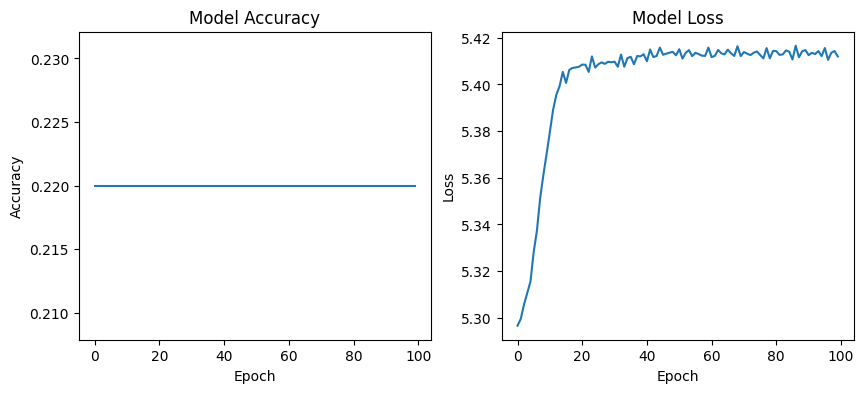

In [ ]:
plot_metrics(history.history)